In [1]:
import numpy as np
import os
import pandas as pd
import itertools
from functools import reduce
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from heatmap import heatmap

In [2]:
#Reward -- change the path according to your location
ac_path = r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Action'
os.chdir(ac_path)
all_file = os.listdir(ac_path)

all_action = []
for i in range(len(all_file)):
    p = list(pd.read_csv(all_file[i])['0'])
    all_action.append(p)
Merge_action = list(itertools.chain(*all_action))
Unique_action = set(Merge_action)
process = list(Unique_action) 

In [3]:
process
state_process = [sub.replace('Add','Formulation') for sub in process]
state_process

['Formulation', 'Cost', 'Remove', 'Analysis', 'Edit', 'Show']

In [4]:
def first_order(file):
    Freq_count_1=pd.DataFrame(0,columns=process,index=process)
    Trans_prob_1=pd.DataFrame(0,columns=process,index=process)
    df=pd.read_csv(file,index_col=False,header=None)
    for i in range(len(process)):
        for j in range(len(process)):
            for k in range(len(df)-1):
                if((process[i]+ process[j])==(df[0][k]+df[0][k+1])):
                    Freq_count_1.iloc[i,j] +=1
    for i in range(len(Trans_prob_1)):
        Trans_prob_1.iloc[i,:]= Freq_count_1.iloc[i,:]/Freq_count_1.iloc[i,:].sum()
    Trans_prob_1=Trans_prob_1.fillna(0)
    return Trans_prob_1

In [5]:
# Preparing training dataset for reward
# 6 student as testing
#os.chdir(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_')
#cluster = pd.read_csv('cluster.csv',index_col=0)
excluded_designer = ['A02','D08','G10','A03','G03','B13']
testing_file = [i +'.csv' for i in excluded_designer]
train_file = [x for x in all_file if x not in testing_file]

In [145]:
#max_len = np.floor(max(len(cluster_1),len(cluster_2))/fold_size_per_clust)
#print(max_len)

In [6]:
def reward_gen(file_list):
    all_trans = []
    for i in range(len(file_list)):
        mc = first_order(file_list[i])
        all_trans.append(mc)
    reward = reduce(lambda x, y: x.add(y, fill_value=0), all_trans)
    return reward

reward = reward_gen(train_file)
reward

,Add,Cost,Remove,Analysis,Edit,Show
Add,20.100995,1.519649,3.727579,1.151116,18.595197,0.905465
Cost,3.418855,2.734077,3.677936,11.929406,19.352603,1.887123
Remove,14.598747,2.347449,15.281270,2.461624,10.467883,0.843026
Analysis,2.439103,12.487813,3.461394,8.113855,15.988862,3.508972
Edit,5.246582,3.526662,2.356709,3.061218,31.196701,0.612128
Show,5.191556,1.774277,2.073067,4.021635,8.931924,16.007540


In [7]:
#location_to_states = {process[x]:x for x in range(len(process))}
def state_location(unique_actions):
    dic = {j:i for i,j in enumerate(unique_actions)}
    return dic
location_to_states = state_location(state_process)
actions = [0,1,2,3,4,5]

state_to_location = dict((state,location) for location, state in location_to_states.items())
location_to_states

{'Formulation': 0, 'Cost': 1, 'Remove': 2, 'Analysis': 3, 'Edit': 4, 'Show': 5}

In [8]:
state_to_location

{0: 'Formulation', 1: 'Cost', 2: 'Remove', 3: 'Analysis', 4: 'Edit', 5: 'Show'}

In [9]:
gamma = 0.3
alpha = 0.1

In [10]:
def Q_table(end_location,reward,alpha,gamma,iteration=10000):
    reward_copy = np.copy(reward)
    ending_state = location_to_states[end_location]
    Q = np.array(np.zeros([6,6]))
    for i in range(iteration):
        current_state = np.random.randint(0,6)    
        playable_actions = []
        for j in range(6):
            if reward_copy[current_state,j]>0:
                playable_actions.append(j)
        next_state = np.random.choice(playable_actions)
        TD = reward_copy[current_state,next_state] + gamma * Q [next_state, np.argmax(Q[next_state,])] - Q[current_state, next_state]
        Q[current_state,next_state] += alpha * TD
    return Q

In [11]:
Q = Q_table('Analysis',reward=reward,alpha=alpha,gamma=gamma)

In [12]:
Q

array([[29.69055852, 11.33643389, 10.98407186,  9.95877857, 31.9652115 ,
         7.76583942],
       [13.0084185 , 12.55086217, 10.93442971, 20.73706898, 32.72261759,
         8.7474968 ],
       [24.18831084, 12.16423459, 22.53776313, 11.26928735, 23.83789785,
         7.70339999],
       [12.02866687, 22.30459811, 10.71788748, 16.92151823, 29.35887657,
        10.36934648],
       [14.83614591, 13.34344697,  9.61320237, 11.86888093, 44.56671545,
         7.47250214],
       [14.78111979, 11.59106183,  9.32956055, 12.82929831, 22.30193888,
        22.86791433]])

# Using maximum 

In [14]:
start_action = 'Formulation'
route = [start_action]
next_action = start_action
for i in range(700):
    starting_state = location_to_states[start_action]
    next_state = np.argmax(Q[starting_state,])
    next_action = state_to_location[next_state]
    route.append(next_action)
    start_action = next_action

In [15]:
np.random.randint(0,6)

4

In [13]:
# Probability function 

def prob(theta,Q):
    a = np.exp(theta * Q)
    return a / a.sum(axis= 0)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def accuracy(pred,actual):
    loss = sum([x != y for x, y in zip(pred, actual)])
    acc = 1 - loss/len(pred)
    return acc

In [14]:
scores = np.array([3.0, 1.0, 0.2])

print(prob(0.3,Q[0,]))
sum(prob(0.5,Q[0,]))

[3.34402775e-01 1.35813005e-03 1.22189164e-03 8.98356941e-04
 6.61653545e-01 4.65301567e-04]


1.0

In [60]:
np.random.choice(prob(0.08,Q[0,]))

0.22737337139401564

In [19]:
random.choice(range(len(prob(0.08,Q[0,]))))

5

In [19]:
total_route = []
for j in np.arange(0.01,0.1,0.01):
    route_50 = []
    for k in range(50):
        start_action = 'Formulation'
        route = [start_action]
    #    next_action = start_action
        for i in range(474):
            starting_state = location_to_states[start_action]
            next_state = random.choice(range(len(prob(j,Q[starting_state,]))))
            next_action = state_to_location[next_state]
            route.append(next_action)
            route = [sub.replace('Formulation','Add') for sub in route]
            start_action = next_action
        route_50.append(route)
    total_route.append(route_50)

In [20]:
route = [sub.replace('Formulation','Add') for sub in route]

In [21]:
prob(0.3,Q[2,])

array([0.00847339, 0.02421208, 0.49197919, 0.01669953, 0.04348422,
       0.4151516 ])

In [22]:
actual = list(pd.read_csv(all_file[1])['0'])
len(list(pd.read_csv(all_file[1])['0']))

327

In [23]:
accuracy(route,actual)

0.4252631578947368

In [24]:
total_accs = [] 
for i in range(len(total_route)):
    temp_acc = []
    for j in range(len(total_route[i])):
        acc = accuracy(total_route[i][j],actual)
        temp_acc.append(acc)
        avg = np.average(temp_acc)
    total_accs.append(avg)

In [27]:
accuracy(total_route[1],actual)

0.0

In [127]:
len(total_route)

1

In [179]:
random.choice(range(len(prob(0.01,Q[5,]))))

4

In [22]:
total_accs

[0.42597894736842107,
 0.4264421052631578,
 0.4264421052631579,
 0.4246736842105263,
 0.42618947368421056,
 0.42766315789473686,
 0.42766315789473686,
 0.42597894736842107,
 0.4274947368421052]

# Only next action 

In [19]:
seq = pd.read_csv(all_file[4])['0']
seq = [sub.replace('Add','Formulation') for sub in seq]

In [36]:
total_route = []
for j in np.arange(0.01,0.1,0.01):
    route_50 = []
    for k in range(50):
        start_action = seq[0]
        route = [start_action]
    #    next_action = start_action
        for i in range(len(seq)-1):
            starting_state = location_to_states[start_action]
            next_state = random.choice(range(len(prob(j,Q[starting_state,]))))
            next_action = state_to_location[next_state]
            route.append(next_action)
            route = [sub.replace('Formulation','Add') for sub in route]
            start_action = seq[i + 1]
        route_50.append(route)
    total_route.append(route_50)

In [37]:
actual = seq

In [38]:
total_accs = [] 
for i in range(len(total_route)):
    temp_acc = []
    for j in range(len(total_route[i])):
        acc = accuracy(total_route[i][j],actual)
        temp_acc.append(acc)
        avg = np.average(temp_acc)
    total_accs.append(avg) 

In [41]:
total_route[1][1][:10]

['Show',
 'Add',
 'Cost',
 'Cost',
 'Edit',
 'Add',
 'Remove',
 'Remove',
 'Analysis',
 'Add']

In [40]:
seq[:10]

['Show',
 'Formulation',
 'Show',
 'Formulation',
 'Formulation',
 'Formulation',
 'Edit',
 'Edit',
 'Edit',
 'Edit']

# Next action for all sequences with 50 iterations

In [15]:
def sequence_generator(file,Q,start_theta=0.01,end_theta=0.3,iteration = 50):
    sequences = []
    for l in range(len(file)):
        seq = pd.read_csv(file[l])['0'] 
        seq = [sub.replace('Add','Formulation') for sub in seq]
        total_route = []
        for j in np.arange(start_theta,end_theta,0.01):
            route_50 = []
            for k in range(iteration):
                start_action = seq[0]
                route = [start_action]
            #    next_action = start_action
                for i in range(len(seq)-1):
                    starting_state = location_to_states[start_action]
                    next_state = random.choices(np.arange(0,6),(prob(j,Q[starting_state,])))[0]
                    next_action = state_to_location[next_state]
                    route.append(next_action)
                    route = [sub.replace('Formulation','Add') for sub in route]
                    start_action = seq[i + 1]
                route_50.append(route)
            total_route.append(route_50)
        sequences.append(total_route)
    return sequences  

In [18]:
sequences = sequence_generator(testing_file,Q)
len(sequences)

6

In [16]:
# For each theta
def accuracy_generator(file,sequence):
    all_accs = []
    for ac in range(len(file)):
        actual = pd.read_csv(file[ac])['0'] 
        actual = [sub.replace('Add','Formulation') for sub in actual]
        pred = sequences[ac]
        total_accs = [] 
        for i in range(len(pred)):
            temp_acc = []
            for j in range(len(pred[i])):
                acc = accuracy(pred[i][j],actual)
                temp_acc.append(acc)
                #avg = np.average(temp_acc)
            total_accs.append(temp_acc)
        all_accs.append(total_accs)
    return all_accs

In [19]:
all_accs = accuracy_generator(testing_file,sequence=sequences)

In [26]:
pd.read_csv(all_file[0])['0'][0]

'Remove'

# Baseline model - Markov

In [36]:
def calc(dataframe,file, random_ = False):
    loss = 0
    sequence = pd.read_csv(file)['0']
    predicted = []
    if random_ == False:
        for i in range(len(sequence) -1):
            a = dataframe.loc[[sequence[i]]].idxmax(axis=1).tolist()
            predicted.append(a)
    else:
        for i in range(len(sequence) - 1):
            col_prob = np.array(dataframe.loc[[sequence[i]]])[0]
            col_id = random.choices(np.arange(0, 6), col_prob)[0]
            a = [dataframe.columns[col_id]]
            predicted.append(a)
    predicted = [item for sublist in predicted for item in sublist]
    label = sequence[1:]
    loss = sum(x != y for x, y in zip(predicted, label))
    accuracy = 1 - loss / float(len(sequence))
    return accuracy


def Train_MC(MC,training_data,process):
    mat = []
    Agg_trans = pd.DataFrame(0, index=process, columns=process)
    for j in range(len(training_data)):
        mat.append(MC(training_data[j]))
    for k in mat:
        Agg_trans += k
    Agg_trans = Agg_trans/len(training_data)
    return  Agg_trans

In [20]:
Fold = 52
fold_size =int(math.ceil(len(all_file)/Fold))

Testing_acc = []
for g in range(Fold):
    #print('\nFold {}'.format(g+1))
    start= g * fold_size
    end = start + fold_size if g + 1 < Fold else len(all_file)
    train=[x for j,x in enumerate(all_file) if j<start or j >= end]
    test=all_file[start:end]
    Agg_trans = Train_MC(first_order,train,process)
    # Testing on Test dataset
    acc = []
    for i in test:
        c = calc(Agg_trans,i, random_= True)
        acc.append(c)
    avg = np.average(acc)
    print('\nFold {}:{} average accuracy : {}'.format(g+1,test,avg))
    Testing_acc.append(avg)
print('\n\nFinal Testing accuracy {}...... Std {}'.format(np.average(Testing_acc),np.std(Testing_acc)))   


Fold 1:['A02.csv'] average accuracy : 0.4408602150537635

Fold 2:['A03.csv'] average accuracy : 0.3700305810397554

Fold 3:['A05.csv'] average accuracy : 0.45171849427168576

Fold 4:['A06.csv'] average accuracy : 0.4758364312267658

Fold 5:['A07.csv'] average accuracy : 0.43767313019390586

Fold 6:['A08.csv'] average accuracy : 0.4156118143459916

Fold 7:['A10.csv'] average accuracy : 0.4130434782608695

Fold 8:['A12.csv'] average accuracy : 0.39344262295081966

Fold 9:['A13.csv'] average accuracy : 0.3870967741935484

Fold 10:['A14.csv'] average accuracy : 0.5137931034482759

Fold 11:['A15.csv'] average accuracy : 0.3890214797136038

Fold 12:['B02.csv'] average accuracy : 0.3807947019867549

Fold 13:['B06.csv'] average accuracy : 0.3793738489871087

Fold 14:['B07.csv'] average accuracy : 0.4948979591836735

Fold 15:['B08.csv'] average accuracy : 0.31958762886597936

Fold 16:['B09.csv'] average accuracy : 0.38604651162790693

Fold 17:['B13.csv'] average accuracy : 0.36274509803921573


In [26]:
np.array(Agg_trans.loc[[pd.read_csv(all_file[0])['0'][0]]])[0]

array([0.04605582, 0.04861114, 0.31388384, 0.33486837, 0.01909591,
       0.23748491])

In [64]:
sequence = pd.read_csv(all_file[0])['0']
col_prob = np.array(Agg_trans.loc[[sequence[0]]])[0]
random.choices(np.arange(0,6),col_prob)[0]

3

In [141]:
random.choices(np.arange(0,6),(prob(0.1,Q[starting_state,])))[0]

4

In [144]:
np.random.choice(np.arange(0,6),p = (prob(0.1,Q[starting_state,])))

3

In [22]:
def theta_df(student,total_file,accuracy,start_theta = 0.01,end_theta = 0.3):
    index = total_file.index(student)
    theta_accs = []
    theta_std = []
    for i in range(len(accuracy[index])):
        acc = np.mean(accuracy[index][i])
        std = np.std(accuracy[index][i])
        theta_accs.append(acc)
        theta_std.append(std)
    theta = list(np.arange(start_theta,end_theta,0.01))
    df = pd.DataFrame({
        'Theta': theta,
        'Accuracy':theta_accs,
        'Std':theta_std
    }, columns=['Theta','Accuracy','Std'])
    return df

In [23]:
def plot_acc(df,student):
    fig = plt.figure()
    ax = fig.gca()
    df.plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(student)[0],yerr = 'Std')
    ax.set_ylabel('Accuracy')

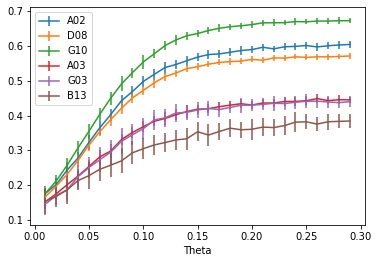

In [36]:
df_list = []
for i in testing_file:
    df_ = theta_df(i,testing_file,all_accs)
    df_list.append(df_)

fig = plt.figure()
ax = fig.gca()
for i in range(len(df_list)):
    df_list[i].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(testing_file[i])[0],yerr = 'Std')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\K-fold result\acc_fold{}.jpg'.format(i),dpi =300)

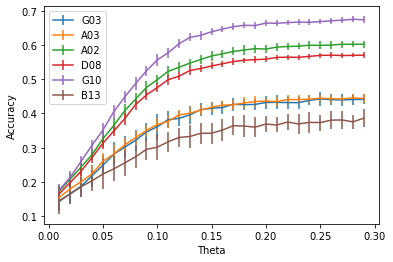

In [89]:
G03 = theta_df('G03.csv',testing_file,all_accs)
A03 = theta_df('A03.csv',testing_file,all_accs)
A02 = theta_df('A02.csv',testing_file,all_accs)
D08 = theta_df('D08.csv',testing_file,all_accs)
G10 = theta_df('G10.csv',testing_file,all_accs)
B13 = theta_df('B13.csv',testing_file,all_accs)

fig = plt.figure()
ax = fig.gca() 
G03.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'G03',yerr = 'Std')
A03.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'A03',yerr = 'Std')
A02.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'A02',yerr = 'Std')
D08.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'D08',yerr = 'Std')
G10.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'G10',yerr = 'Std')
B13.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'B13',yerr = 'Std')
ax.set_ylabel('Accuracy')
os.chdir(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result')
plt.savefig('plot_for_3.jpg',format = 'jpg',dpi = 300)

# K-fold cross validation


Fold 1


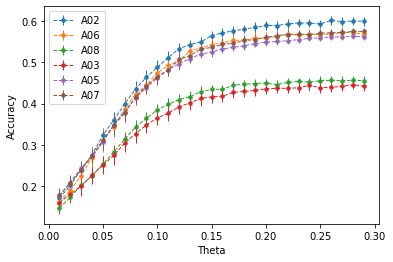


Fold 2


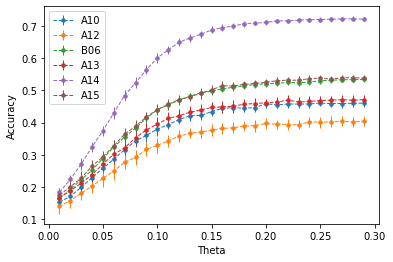


Fold 3


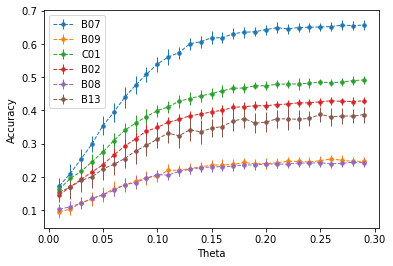


Fold 4


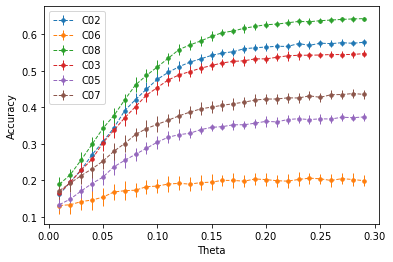


Fold 5


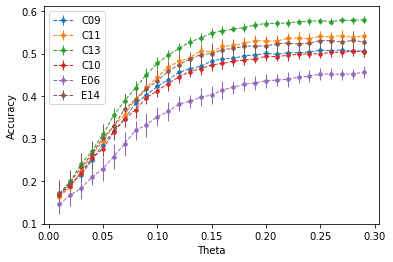


Fold 6


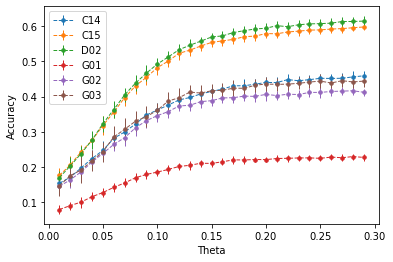


Fold 7


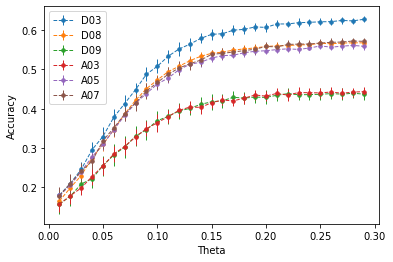


Fold 8


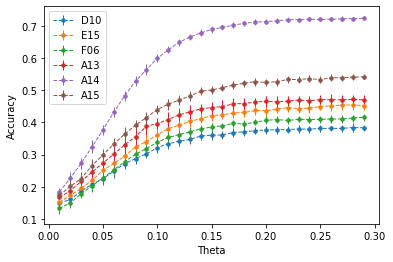


Fold 9


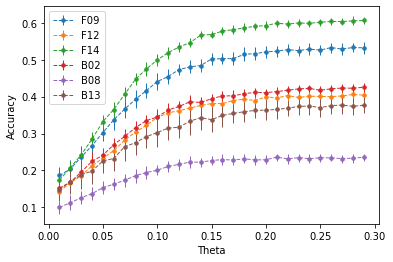


Fold 10


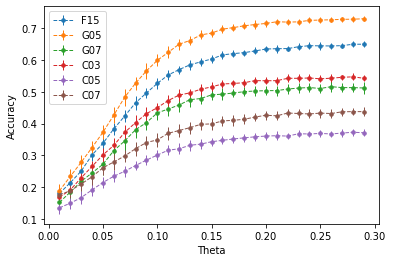


Fold 11


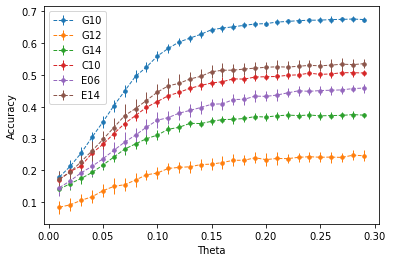

In [26]:
#for K-fold cross validation
os.chdir(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_')
cluster = pd.read_csv('cluster.csv',index_col=0)
cluster = cluster.replace(np.nan,'')
cluster_1 = list(cluster.iloc[:,0])
cluster_2 = list(cluster.iloc[:,1])
cluster_2 = [x for x in cluster_2 if x != '']

os.chdir(ac_path)
fold_size_per_clust = 3
max_len = np.int32(np.floor(max(len(cluster_1),len(cluster_2))/fold_size_per_clust))
for i in range(max_len):
    print('\nFold {}'.format(i+1))
    start = fold_size_per_clust * i
    end = start + fold_size_per_clust 
    clus1 = cluster_1[start:end]
    if start > len(cluster_2) - 3:
        start_1 = (i-6)*fold_size_per_clust
        end_1 = start_1 + fold_size_per_clust
        clus2 = cluster_2[start_1:end_1]
    else:
        clus2 = cluster_2[start:end]
    excluded_designer = clus1 + clus2
    testing_file = [i +'.csv' for i in excluded_designer]
    train_file = [x for x in all_file if x not in testing_file]
#    print(testing_file)
    reward = reward_gen(train_file)
    Q = Q_table('Analysis',reward=reward,alpha=alpha,gamma=gamma)
    sequences = sequence_generator(testing_file,Q)
    all_accs = accuracy_generator(testing_file,sequence=sequences)
    df_list = []
    for k in testing_file:
        df_ = theta_df(k,testing_file,all_accs)
        df_list.append(df_)

    #fig = plt.figure()
    #ax = fig.gca()
    for j in range(len(df_list)):
        plt.errorbar(df_list[j].Theta, df_list[j].Accuracy, linestyle='dashed', yerr = df_list[j].Std, label = os.path.splitext(testing_file[j])[0],
                    marker = '.', ms = 7, linewidth= 1)
        plt.xlabel('Theta')
        plt.ylabel('Accuracy')
        plt.legend(loc = 'upper left')
        #df_list[j].plot(kind = 'line', style = ["g--"], x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(testing_file[j])[0],yerr = 'Std')
    plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\K-fold result\acc_fold_{}.jpg'.format(i),dpi =300)
    plt.show()

<ErrorbarContainer object of 3 artists>

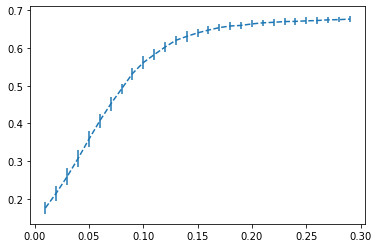

In [77]:
plt.errorbar(df_list[0].Theta, df_list[0].Accuracy, linestyle='dashed', yerr = df_list[0].Std)

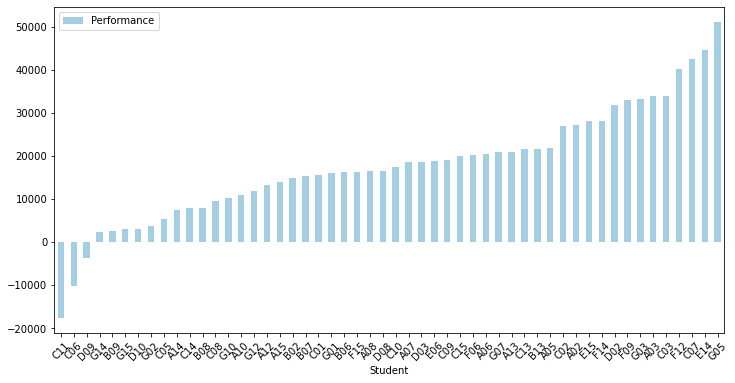

In [30]:
performace = pd.read_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\performance.csv',index_col=None)
h_perform = performace.sort_values('Weighted ANE')
h_perform.plot.bar(x = 'Student',y='Weighted ANE',rot = 45,figsize = (12,6),colormap='Paired')
plt.legend(["Performance"])

# High performer group

In [31]:
high_perform_10 = list(h_perform['Student'])[-10:]
high_perform_10

['F14', 'D02', 'F09', 'G03', 'A03', 'C03', 'F12', 'C07', 'E14', 'G05']

In [32]:
testing_file_10 = [i +'.csv' for i in high_perform_10]
train_file_10 = [x for x in all_file if x not in testing_file_10]

In [33]:
reward_10 = reward_gen(train_file_10)

### Average Markov Chain prediction

In [37]:
trans = Train_MC(first_order, training_data=train_file_10, process=process)

In [26]:
MC_T_10 = []
for file in testing_file_10:
#    a = pd.read_csv(file)
    ac = calc(trans, file, random_= True)
    MC_T_10.append(ac)
MC_T10 = pd.DataFrame(list(zip(MC_T_10, high_perform_10)), columns = ['MC_T_10', 'Student'])
MC_T10.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Compare\MC_avg_T.csv')

In [38]:
Q = Q_table('Analysis',reward=reward,alpha=alpha,gamma=gamma)
sequences = sequence_generator(testing_file_10,Q)
all_accs = accuracy_generator(testing_file_10,sequence=sequences)
final_accs_top_10 = []
final_accs_top_std = []
for i in range(len(all_accs)):
    x = np.mean(all_accs[i][28])
    y = np.std(all_accs[i][28])
    final_accs_top_10.append(x)
    final_accs_top_std.append(y)

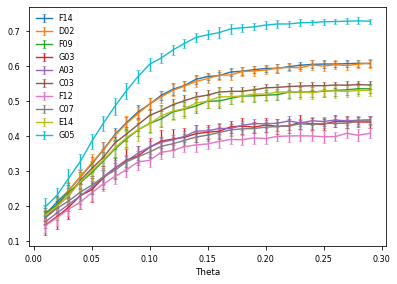

In [35]:
plt.style.use('seaborn-paper')
df_list_10 = []
for k in testing_file_10:
    df_ = theta_df(k,testing_file_10,all_accs)
    df_list_10.append(df_)

fig = plt.figure()
ax = fig.gca()
for j in range(len(df_list_10)):
    df_list_10[j].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(testing_file_10[j])[0],yerr = 'Std',capsize=2,capthick=0.5)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top.jpg'.format(i),dpi =300)

<Figure size 576x576 with 0 Axes>

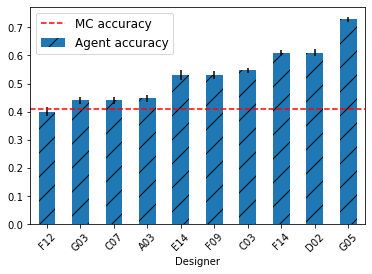

In [39]:
high_df = pd.DataFrame({'Designer':high_perform_10,'Accuracy':final_accs_top_10,'Std':final_accs_top_std})
high_df = high_df.sort_values('Accuracy')
plt.figure(figsize=(8,8))
ax = high_df.plot.bar(x = 'Designer',y = 'Accuracy',yerr = 'Std',rot = 45,hatch = '/')
plt.xticks(fontsize=10)
plt.yticks(fontsize = 10)
plt.axhline(y=0.41, color='r', linestyle='--')
plt.legend(["MC accuracy","Agent accuracy"],fontsize = 12)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\accuracy_top.jpg',dpi = 300,bbox_inches = 'tight')
high_df.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\accuracy_top.csv')

In [37]:
peroform_top_10 = (h_perform['Weighted ANE'])[-10:]
df_top_10 = pd.DataFrame(list(zip(high_perform_10,peroform_top_10,final_accs_top_10)),columns=['Student','ANE','Accuracy'])
df_top_10.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Compare\top10.csv')

[Text(0.5, 0, 'ANE'), Text(1.5, 0, 'Accuracy')]

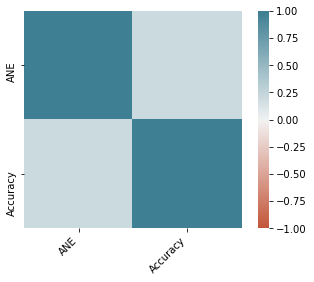

In [32]:
corr = df_top_10.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [34]:
print(corr)

               ANE  Accuracy
ANE       1.000000  0.206244
Accuracy  0.206244  1.000000


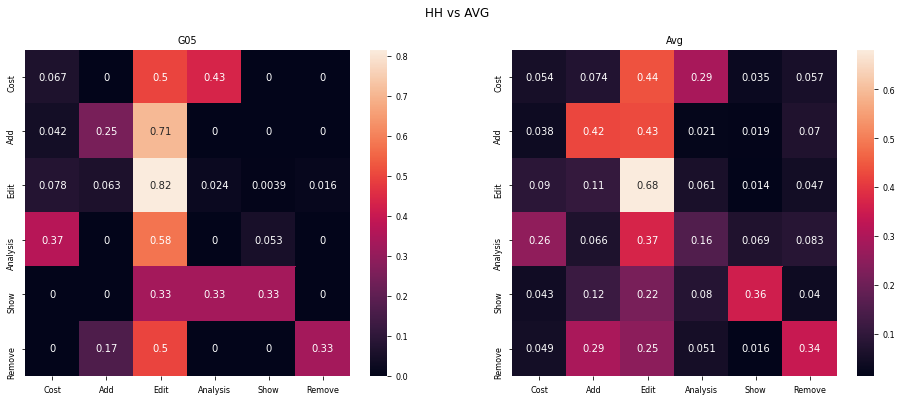

In [160]:
 # Comparision of Highest performer MC vs Average MC
h_mc = reward_gen(['G05.csv'])
h_avg = reward_10/42

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(h_mc,annot=True,ax=ax[0]).set_title('G05')
sns.heatmap(h_avg,annot= True,ax = ax[1]).set_title('Avg')
plt.suptitle('HH vs AVG')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\h_av.jpg',dpi = 300)

In [89]:
sum(h_avg.iloc[0])

0.9523809523809524

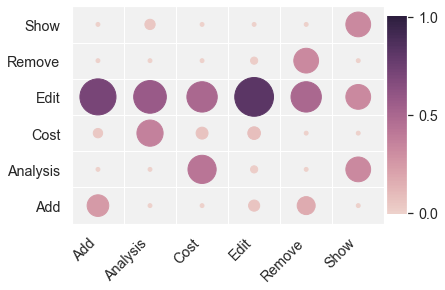

In [177]:
def mat_converter(mat):
    m = pd.melt(mat.reset_index(),id_vars = 'index')
    m.columns = ['x','y','value']
    return m
t = mat_converter(h_mc.round(2))
plt.figure(figsize=(6, 4))
sns.set(font_scale = 1.3)
heatmap(
    x=t['x'],
    y=t['y'],
    size=t['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=t['value'],
    size_scale = 1500,
    color_range = (0,1)
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\G05.jpg',dpi = 300,bbox_inches = 'tight')

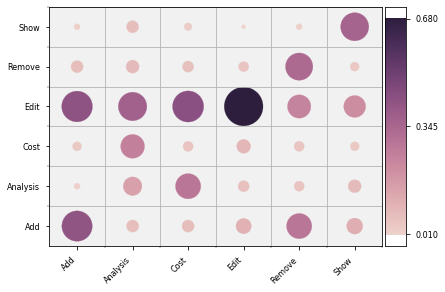

In [169]:
avg = mat_converter(h_avg.round(2))
heatmap(
    x=avg['x'],
    y=avg['y'],
    size=avg['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=avg['value'],
    size_scale = 1500
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\AVG.jpg',dpi = 300)

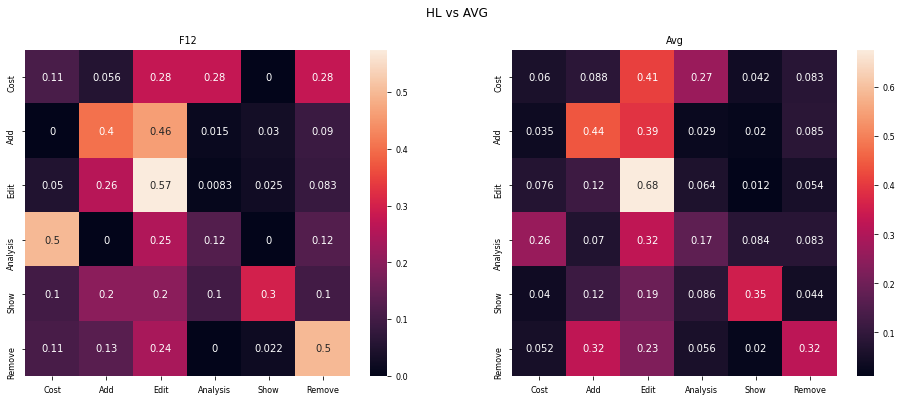

In [74]:
lh_mc = reward_gen(['F12.csv'])

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(lh_mc,annot=True,ax=ax[0]).set_title('F12')
sns.heatmap(h_avg,annot= True,ax = ax[1]).set_title('Avg')
plt.suptitle('HL vs AVG')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\l_av.jpg',dpi = 300)

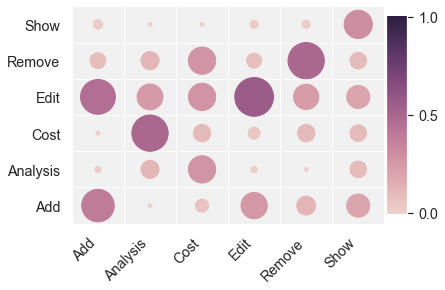

In [175]:
low_h = mat_converter(lh_mc.round(2))
plt.figure(figsize=(6, 4))
sns.set(font_scale = 1.3)
heatmap(
    x=low_h['x'],
    y=low_h['y'],
    size=low_h['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=low_h['value'],
    size_scale = 1500,
    color_range = (0,1)
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\low.jpg',dpi = 300,bbox_inches = 'tight')

# Low Performer

In [40]:
low_perform_10 = list(h_perform['Student'])[:10]
low_perform_10
testing_file_10_low = [i +'.csv' for i in low_perform_10]
train_file_10_low = [x for x in all_file if x not in testing_file_10_low]
reward_10 = reward_gen(train_file_10_low)
low_perform_10

['C11', 'C06', 'D09', 'G14', 'B09', 'G15', 'D10', 'G02', 'C05', 'A14']

### Average Markov accuracy

In [41]:
trans = Train_MC(first_order,train_file_10_low, process)

In [34]:
MC_L_10 = []
for file in testing_file_10_low:
    #    a = pd.read_csv(file)
    ac = calc(trans, file, random_= True)
    MC_L_10.append(ac)
MC_L10 = pd.DataFrame(list(zip(MC_L_10, low_perform_10)), columns = ['MC_L_10', 'Student'])
MC_L10.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Compare\MC_avg_L.csv')

In [42]:
Q_low = Q_table('Analysis',reward=reward,alpha=alpha,gamma=gamma)
sequences = sequence_generator(testing_file_10_low,Q_low)
all_accs = accuracy_generator(testing_file_10_low,sequence=sequences)
final_accs_low_10 = []
final_accs_low_std = []
for i in range(len(all_accs)):
    x = np.mean(all_accs[i][28])
    y = np.std(all_accs[i][28])
    final_accs_low_10.append(x)
    final_accs_low_std.append(y)

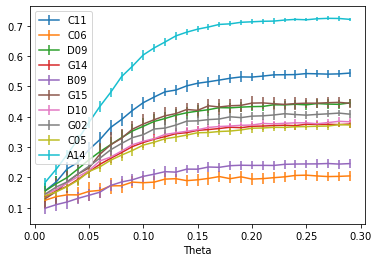

In [91]:
df_list_10 = []
for k in testing_file_10_low:
    df_ = theta_df(k,testing_file_10_low,all_accs)
    df_list_10.append(df_)

fig = plt.figure()
ax = fig.gca()
for j in range(len(df_list_10)):
    df_list_10[j].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(testing_file_10_low[j])[0],yerr = 'Std')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\Low_10.jpg'.format(i),dpi =300)

<Figure size 576x576 with 0 Axes>

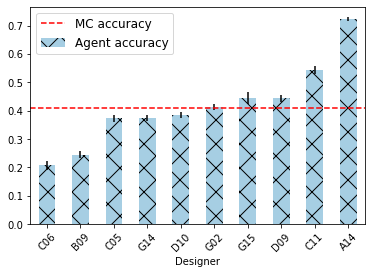

In [43]:
low_df = pd.DataFrame({'Designer':low_perform_10,'Accuracy':final_accs_low_10,'Std':final_accs_low_std})
low_df = low_df.sort_values('Accuracy')
plt.figure(figsize=(8,8))
ax = low_df.plot.bar(x = 'Designer',y = 'Accuracy',yerr = 'Std',rot = 45,colormap='Paired',hatch = 'x')
plt.xticks(fontsize=10)
plt.yticks(fontsize = 10)
plt.axhline(y=0.41, color='r', linestyle='--')
plt.legend(["MC accuracy","Agent accuracy"],fontsize = 12)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\accuracy_low.jpg',dpi = 300,bbox_inches = 'tight')
low_df.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\accuracy_low.csv')

In [42]:
peroform_low_10 = (h_perform['Weighted ANE'])[:10]
df_low_10 = pd.DataFrame(list(zip(low_perform_10,peroform_low_10,final_accs_low_10)),columns=['Student','ANE','Accuracy'])
df_low_10.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Compare\low10.csv')

In [181]:
corr = df_low_10.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

NameError: name 'df_low_10' is not defined

In [95]:
print(corr)

               ANE  Accuracy
ANE       1.000000  0.460805
Accuracy  0.460805  1.000000


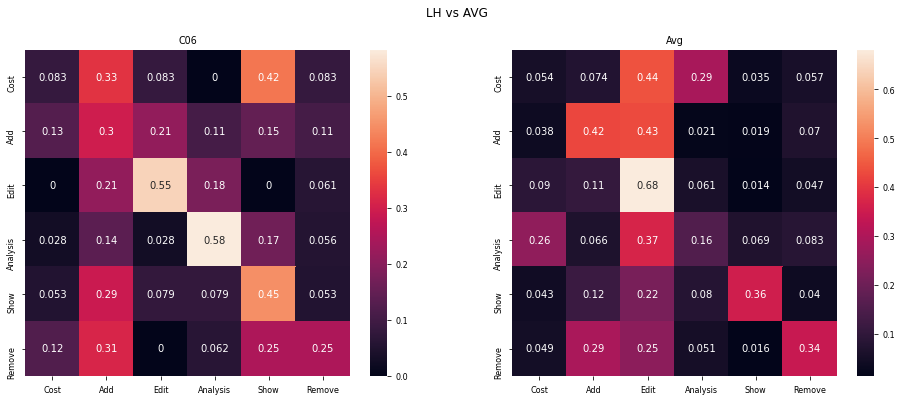

In [151]:
# Comparision of Highest performer MC vs Average MC
l_mc = reward_gen(['C06.csv'])
h_avg = reward_10/42

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(l_mc,annot=True,ax=ax[0]).set_title('C06')
sns.heatmap(h_avg,annot= True,ax = ax[1]).set_title('Avg')
plt.suptitle('LH vs AVG')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\low one vs top low\l_av.jpg',dpi = 300)

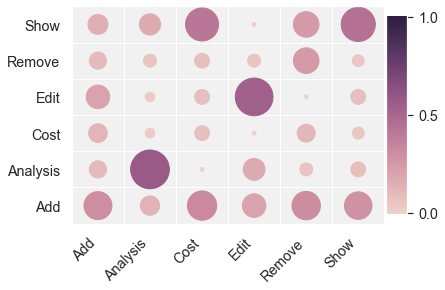

In [186]:
low_h = mat_converter(l_mc.round(2))
plt.figure(figsize=(6, 4))
sns.set(font_scale = 1.3)
heatmap(
    x=low_h['x'],
    y=low_h['y'],
    size=low_h['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=low_h['value'],
    size_scale = 1500,
    color_range  = (0,1)
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\low_low.jpg',dpi = 300,bbox_inches = 'tight')

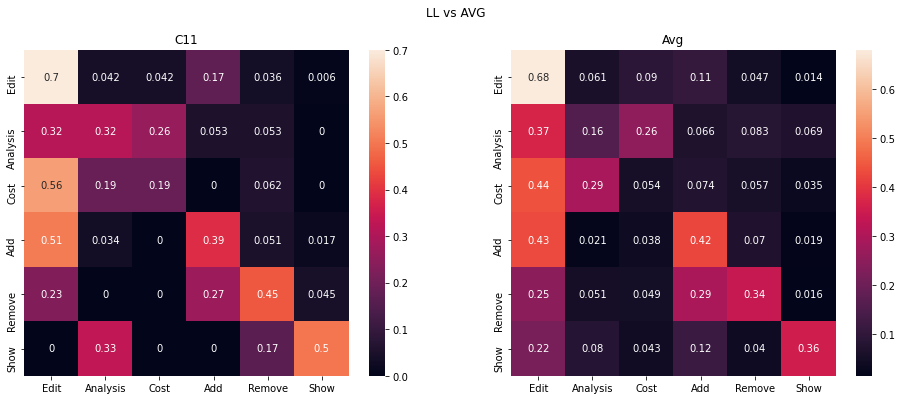

In [99]:
hl_mc = reward_gen(['C11.csv'])

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(hl_mc,annot=True,ax=ax[0]).set_title('C11')
sns.heatmap(h_avg,annot= True,ax = ax[1]).set_title('Avg')
plt.suptitle('LL vs AVG')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\low one vs top low\hl_av.jpg',dpi = 300)

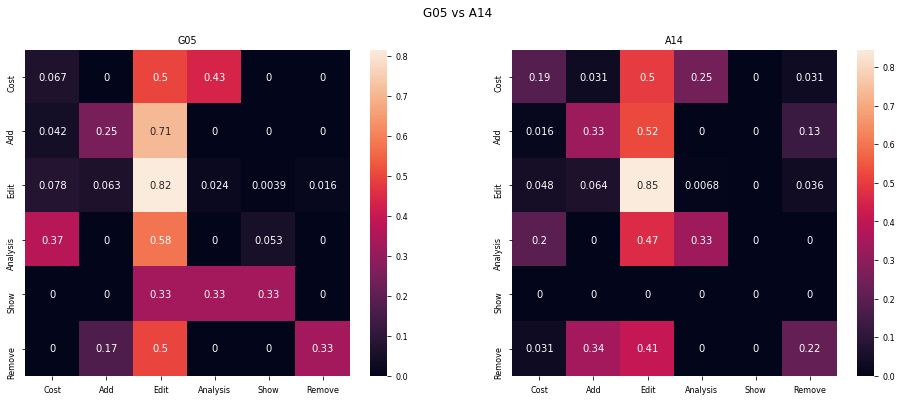

In [155]:
 # Comparision of Highest performer in high group vs highest performer in low group

h_mc = reward_gen(['G05.csv'])
A14 = reward_gen(['A14.csv'])
h_avg = reward_10/42

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(h_mc,annot=True,ax=ax[0]).set_title('G05')
sns.heatmap(A14,annot= True,ax = ax[1]).set_title('A14')
plt.suptitle('G05 vs A14')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\G05_A14.jpg',dpi = 300)

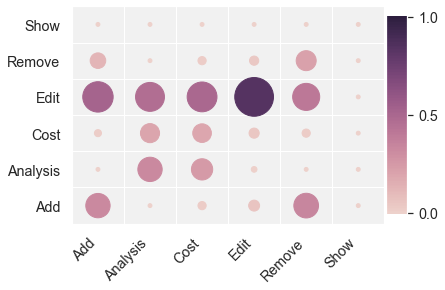

In [187]:
A14_ = mat_converter(A14.round(2))
plt.figure(figsize=(6, 4))
sns.set(font_scale = 1.3)
heatmap(
    x=A14_['x'],
    y=A14_['y'],
    size=A14_['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=A14_['value'],
    size_scale = 1500,
    color_range = (0,1)
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\A14.jpg',dpi = 300,bbox_inches = 'tight')

# Train on high performance designer

In [134]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
alpha = 0.1
gamma = 0.9
start_theta = 0.1
end_theta = 2

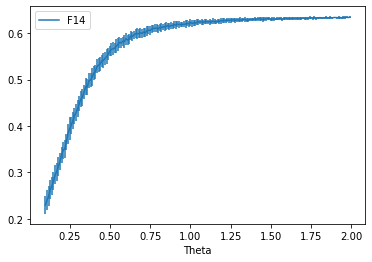

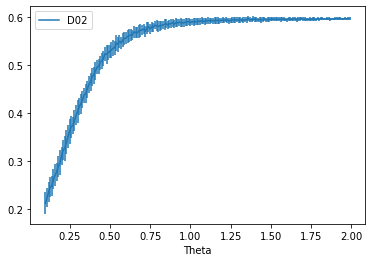

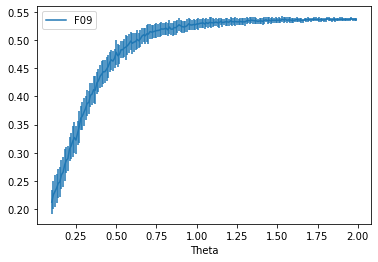

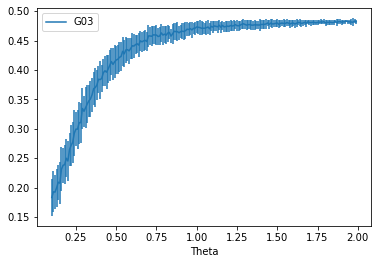

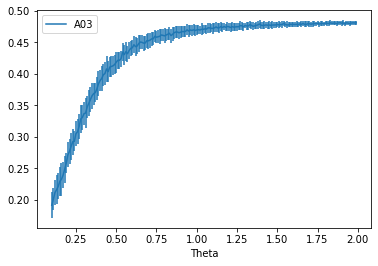

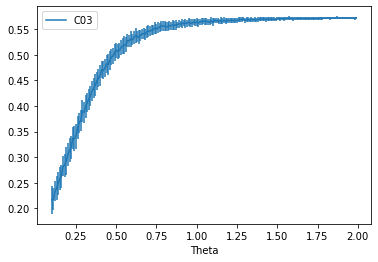

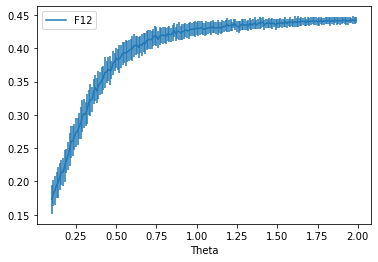

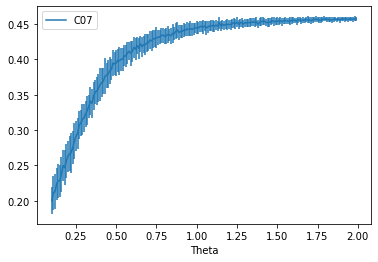

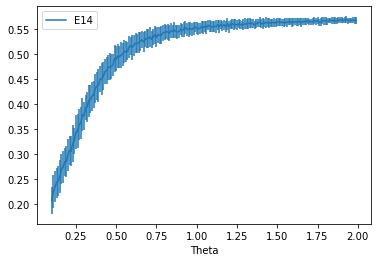

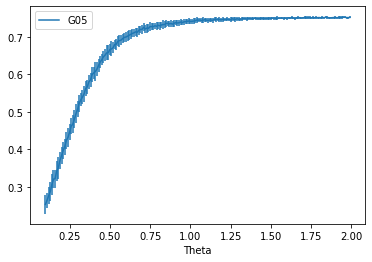

In [135]:
for train_index,test_index in loo.split(testing_file_10):
    train = [testing_file_10[x] for x in train_index]
    test =  [testing_file_10[x] for x in test_index]
    Q = Q_table('Analysis',reward=reward_gen(train),alpha=alpha,gamma=gamma)
    sequences = sequence_generator(test,Q,start_theta=start_theta,end_theta=end_theta)
    all_accs = accuracy_generator(test,sequence=sequences)
    df_list = []
    for k in test:
        df_ = theta_df(k,test,all_accs,start_theta=start_theta,end_theta=end_theta)
        df_list.append(df_)

    fig = plt.figure()
    ax = fig.gca()
    for j in range(len(df_list)):
        df_list[j].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(test[j])[0],yerr = 'Std')
    plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\Only_top\test_{}.jpg'.format(test_index[0]),dpi =300)       

# Testing next action based on predicted action

In [162]:
def sequence_generator_predicted(file,Q,start_theta=0.01,end_theta=0.3,iteration = 50):
    sequences = []
    for l in range(len(file)):
        seq = pd.read_csv(file[l])['0'] 
        seq = [sub.replace('Add','Formulation') for sub in seq]
        total_route = []
        for j in np.arange(start_theta,end_theta,0.01):
            route_50 = []
            for k in range(iteration):
                start_action = seq[0]
                route = [start_action]
            #    next_action = start_action
                for i in range(len(seq)-1):
                    starting_state = location_to_states[start_action]
                    next_state = random.choices(np.arange(0,6),(prob(j,Q[starting_state,])))[0]
                    next_action = state_to_location[next_state]
                    route.append(next_action)
                    route = [sub.replace('Formulation','Add') for sub in route]
                    start_action = next_action
                route_50.append(route)
            total_route.append(route_50)
        sequences.append(total_route)
    return sequences

In [161]:
G05 = ['G05.csv']
other = [x for x in all_file if x not in testing_file_10_low]
rwrd_toal = reward_gen(other)
rwrd_toal

,Cost,Add,Edit,Analysis,Show,Remove
Cost,2.257088,3.128367,18.463265,12.292608,1.456469,2.402202
Add,1.594395,17.814222,18.009188,0.863770,0.777992,2.940434
Edit,3.775691,4.486128,28.622702,2.542122,0.589675,1.983683
Analysis,10.720313,2.787425,15.540781,6.570547,2.898771,3.482163
Show,1.819936,4.911071,9.208477,3.360045,15.027716,1.672756
Remove,2.066795,12.316035,10.455032,2.129087,0.653745,14.379307


In [163]:
Q_total = Q_table('Analysis',reward=rwrd_toal,alpha=alpha,gamma=gamma)
sequences = sequence_generator_predicted(G05,Q_total)
all_accs = accuracy_generator(G05,sequence=sequences)

In [164]:
Q_total

array([[11.47612903, 12.21118529, 30.73013756, 20.63490429,  7.89907409,
         9.21877287],
       [10.81343583, 26.8970396 , 30.27606013,  9.20606618,  7.22059673,
         9.75700457],
       [12.99473191, 13.56894578, 40.88957405, 10.88441814,  7.03227961,
         8.80025361],
       [19.93935449, 11.87024264, 27.8076532 , 14.91284323,  9.34137542,
        10.29873415],
       [11.03897683, 13.99388893, 21.47534955, 11.7023407 , 21.47032045,
         8.48932671],
       [11.28583603, 21.39885279, 22.7219038 , 10.47138246,  7.09635029,
        21.19587777]])

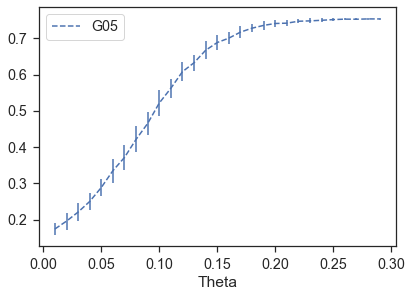

In [201]:
sns.set_style("ticks")
df_list_G05 = []
for k in G05:
    df_ = theta_df(k,G05,all_accs)
    df_list_G05.append(df_)

fig = plt.figure()
ax = fig.gca()
for j in range(len(df_list_G05)):
    df_list_G05[j].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(G05[j])[0],yerr = 'Std',linestyle = '--')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\G05\G05.jpg'.format(i),dpi =300)